# PROJECT DETAILS
- PROJECT NAME : CREDIT RISK MODELING
- AUTHOR : Maria Jose Valbuena Bustos ( Data Scientist )
- PROJECT CONTEXT: Final Task of Project-based Internship (Rakamin Academy X ID/X Partners)
- AREA : Data Science
- PROJECT MENTOR : Anugrah Muzakki Puar
- PROJECT STATUS : On-Progress
- SUBMISSION DATE : 29th October 2023
- PROJECT REPOSITORY : https://github.com/vb-maria/credit_risk_modeling.git

### Side Notes
- This individual project is the Final Task of the indonesian Project-Based Internship by Rakamin Academy and ID/X Partners assigned to Maria Jose Valbuena Bustos with the excellent mentorship by Anugrah Muzakki Puar.

- Maria Jose is a Data Scientist from Spain who has relocated to Indonesia has graduated from Rakamin's Data Science Bootcamp.

- This project consists of a dataset and a data dictionary provided by ID/X Partners, the source code in Python and a Power Point delivered on 30th October 2023.


# PROJECT SETUP

## Library and module importing

In [ ]:
# > --- Uncomment if needed
# !pip install ptitprince
# !pip install lightgbm
# !pip install xgboost
# !pip install tabulate
# !pip install ydata-profilingr 
# pip install nbconvert

In [211]:
# Environment-related
import warnings
from IPython.display import Image
from tabulate import tabulate

# Preprocessing-related modules
import pandas as pd
import numpy as np
from numpy import percentile
from scipy.stats import uniform
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE


# Visualization-related modules
import ptitprince as pt
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

# Imbalance-related modules
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# ML- Related modules
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score, RandomizedSearchCV

# - Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## Configuration

In [351]:
# Parameters
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 999)
%matplotlib inline
import seaborn as sns
import matplotlib.colors as mcolors

# Define the base colors you want to repeat
first = '#c8d90f'
second = '#15538c'
third = "#898989"
fourth = "#ccc"

# Define the number of times you want to repeat each base color
repetitions = 20  # You can adjust this number as needed

# Initialize an empty custom_palette list
custom_palette = []

# Append the base colors to the custom_palette
for _ in range(repetitions):
    custom_palette.extend([first, second, third, fourth])

# Set the custom palette as the default palette in Seaborn
sns.set_palette(custom_palette)

# Define a custom colormap using the first two colors in the palette
themed_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [custom_palette[0], custom_palette[1]])


### CUSTOM FUNCTIONS:

#### DATA UNDESTANDDING

In [213]:
def get_columns(df, usable=True):
    type_dict = type_columns(df)
    type_keys = list(type_dict.keys())
    cat_binary = type_keys[0]
    cat_other = type_keys[1]
    temporal = type_keys[2]
    numerical = type_keys[3]
    fully_null = type_keys[4]
    constant = type_keys[5]

    cols_fully_null = type_dict[fully_null]
    cols_constant = type_dict[constant]
    cols_cat_binary = type_dict[cat_binary]
    cols_cat_other = type_dict[cat_other]
    cols_temporal = type_dict[temporal]
    cols_numerical = type_dict[numerical]
    cols_categorical = join_column_lists(cols_cat_binary, cols_cat_other)
    
    if usable:
        return categorical_binary, categorical_other, temporal, numerical
    else:
        return categorical_binary, categorical_other, temporal, numerical, fully_null, constant

In [214]:
from tabulate import tabulate

def print_table(table_title, column_titles, *results):
    # Create a list to hold the table
    table = []

    # Add the table title as the first row
    title_row = [f"\033[1m{table_title}\033[0m"] + (([""] * (len(column_titles)-len(table_title))))  # Include '##' before the title
    table.append(title_row)

   

    # Add the column titles as the third row
    table.append(column_titles)
    
    
 # Add empty row as a separator
    table.append([""] * len(column_titles))
    # Find the maximum length of results
    max_length = max(len(result) for result in results)

    # Add the results rows
    for i in range(max_length):
        row_values = []
        for result in results:
            if i < len(result):
                row_values.append(result[i])
            else:
                row_values.append('')
        table.append(row_values)

    # Use tabulate to format the data
    formatted_table = tabulate(table, headers="firstrow", tablefmt='pipe', numalign='left', stralign='left')

    # Print the formatted table
    print(formatted_table)

In [215]:
def get_data_type(df, column_name):
        data_type = df[column_name].dtype
        return data_type

In [216]:
def type_columns(df, usable=False):
    categorical_binary = []
    categorical_other = []
    numerical = []
    temporal = []
    fully_null = []
    constant = []

    for col in df.columns:
        col_data_type = get_data_type(df, col)
        unique_values = df[col].unique()

        if pd.api.types.is_numeric_dtype(col_data_type):
            if len(unique_values) == 2:
                categorical_binary.append(col)
            elif len(unique_values) == 1:
                if df[col].isna().all():
                    fully_null.append(col)
                else:
                    constant.append(col)
            else:
                numerical.append(col)
        elif pd.api.types.is_datetime64_any_dtype(col_data_type) or pd.api.types.is_timedelta64_dtype(col_data_type):
            temporal.append(col)
        else:
            if len(unique_values) == 2:
                categorical_binary.append(col)
            elif len(unique_values) == 1:
                if df[col].isna().all():
                    fully_null.append(col)
                else:
                    constant.append(col)
            else:
                categorical_other.append(col)

    # Sort the category lists
    categorical_binary = sorted(categorical_binary)
    categorical_other = sorted(categorical_other)
    temporal = sorted(temporal)
    numerical = sorted(numerical)
    fully_null = sorted(fully_null)
    constant = sorted(constant)

    if usable:
        return categorical_binary, categorical_other, temporal, numerical
    else:
        return categorical_binary, categorical_other, temporal, numerical, fully_null, constant

In [217]:
def get_valid_row(df):
    valid_row = None
    missing_values_count = df.isnull().sum(axis=1)
    valid_row_index = missing_values_count.idxmin()
    valid_row = df.loc[valid_row_index]
    return valid_row

def get_invalid_row(df):
    invalid_row = None
    missing_values_count = df.isnull().sum(axis=1)
    invalid_row_index = missing_values_count.idxmax()
    invalid_row = df.loc[invalid_row_index]
    return invalid_row



def get_row_value_type(df, row, columns):
    if row is not None:
        results = []
        for col in columns:
            col_name = col
            col_value = row[col]
            col_type = get_data_type(df, col)  # Get the type of the col_value
            result = f"{col_name}: {col_value} ({col_type})"  # Append the type information
            results.append(result)
        return results
    else:
        return []

In [218]:
def join_column_lists(cols1, cols2):
    cols = cols1 + cols2
    return cols

def exclude_elements(list1, list2):
    """
    Exclude elements from list2 out of list1 and return the resulting list.

    Parameters:
        list1 (list): The complete list.
        list2 (list): The list of elements to be excluded from list1.

    Returns:
        list: A list containing elements from list1 with elements of list2 removed.
    """
    return [item for item in list1 if item not in list2]

def update_list(df, list1, list2, list_name="", message="", show_update="True"):
    new_list = join_column_lists(list1, list2)
    df_filtered = df[new_list]
    if show_update:
        print(f"{list_name} {message}:")
        print(new_list)
    return  new_list, df_filtered

In [219]:
def calculate_missing_percentages(df, threshold=50):
    # Calculate the percentage of missing values for each column
    missing_percentage = round((df.isna().sum() / len(df)) * 100)

    # Create a DataFrame to store missing percentage information
    missing_info = pd.DataFrame({'Column': missing_percentage.index, 'Missing Percentage': missing_percentage.values})

    # Sort the missing_info DataFrame by the 'Missing Percentage' column in descending order
    missing_info = missing_info.sort_values(by='Missing Percentage', ascending=False)

    # Filter the DataFrame into two lists based on the threshold
    low_col = missing_info[missing_info['Missing Percentage'] < threshold]['Column'].tolist()
    low_val = missing_info[missing_info['Missing Percentage'] < threshold]['Missing Percentage'].tolist()
    high_col = missing_info[missing_info['Missing Percentage'] >= threshold]['Column'].tolist()
    high_val = missing_info[missing_info['Missing Percentage'] >= threshold]['Missing Percentage'].tolist()
    
    return low_col, low_val, high_col, high_val


In [220]:
def columns_from_threshold(col_list, val_list, up_threshold=100):
    from_threshold = [col for col, val in zip(col_list, val_list) if val >= up_threshold]
    return from_threshold

def columns_within_threshold(col_list, val_list, down_threshold=100, up_threshold=100):
    within_threshold = [col for col, val in zip(col_list, val_list) if down_threshold < val < up_threshold]
    return within_threshold

In [221]:
import numpy as np
import pandas as pd

def analyze_numerical_distribution(df, column_name):
    data = df[column_name].dropna()
    desc = data.describe()
    data_max = data.max()
    data_min = data.min()
    median = data.median()
    mean = data.mean()
    mode = data.mode()
    std = data.std()
    
    # Check symmetry
    is_symmetric = "Symmetrical" if np.abs(mean - median) < 0.1 * std else "Not Symmetrical"
    
    # Check uniformity
    range_diff = data_max - data_min
    is_uniform = "Uniform" if std < 0.1 * range_diff else "Not Uniform"
    
    # Check for modality
    unique_values = len(data.unique())
    if unique_values == 1:
        modality = "Unimodal"
    elif unique_values == 2:
        modality = "Bimodal"
    else:
        modality = "Multimodal"
    
    # Check for skewness
    skewness = "Positive Skew" if mean > median else "Negative Skew" if mean < median else "No Skew"
    
    # Check for outliers (based on IQR)
    Q1 = desc["25%"]
    Q3 = desc["75%"]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    has_outliers = any((data < lower_bound) | (data > upper_bound))
    
    mean = round(mean)
    median = round(median)
    std = round(std)
    IQR = round(IQR)
    mode = mode.iloc[0]  # Extract the mode as a value
    
    print(f"Statistical Summary of: {column_name}")
    print(f"- Central Tendency Measures -> Mean: {mean} | Median: {median} | Mode: {mode}")
    print(f"- Spread Measures -> Standard Deviation: {std} | Interquartile Range (IQR): {IQR}")
    print(f"- Distribution Characteristics:")
    print(f"  Symmetry: {is_symmetric}")
    print(f"  Uniformity: {is_uniform}")
    print(f"  Modality: {modality}")
    print(f"  Skewness: {skewness}")
    print(f"  Outliers: {'Yes' if has_outliers else 'No'}")
    print("-"*75)

#### VISUALIZATION

In [222]:
## RELATED TO PLOT LAYOUT
    
def withingrid_calculate_best_num(total_plots):
    best_num_cols = 4  # Set the number of columns to 4
    best_num_rows = int(math.ceil(total_plots / best_num_cols))
    return best_num_cols, best_num_rows    

def layout(total_plots):
    best_num_cols = 4
    best_num_rows = (total_plots + best_num_cols - 1) // best_num_cols
    return best_num_rows, best_num_cols
    
def calculate_best_num(total_plots):
    if total_plots >= 1 and total_plots <= 3:
        best_num_cols = total_plots
        best_num_rows = 1
    elif total_plots < 15:
        best_num_cols = int(math.ceil(math.sqrt(total_plots)))
        best_num_rows = int(math.ceil(total_plots / best_num_cols))
    else:
        best_num_cols = 4
        best_num_rows = int(math.ceil(total_plots / best_num_cols))
    return best_num_cols, best_num_rows

def calculate_axis(total_plots, best_num_cols, axs, index):
    if total_plots == 1:
        ax = axs
        return ax
    elif total_plots > 1:
        if best_num_rows == 1:
            axis_single_row = axs[index]
            return axis_single_row
        else:
            axis_multi_row = axs[index // best_num_cols, index % best_num_cols]
            return axis_multi_row
    else:
        return print('Error')
    
def remove_empty_subplots(axs, i, fig):
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

In [224]:
## MANUAL WAY

def withingrid_manual_with_function(df, custom_functions, figsize=(20, 10)):
    total_plots = len(custom_functions)
    best_num_cols, best_num_rows = layout(10)
    fig, axs = plt.subplots(nrows=best_num_rows, ncols=best_num_cols, figsize=figsize)
    axs = axs.ravel()  # Flatten the 2D array

    for i, custom_function in enumerate(custom_functions):
        if not callable(custom_function):
            print(f"Invalid function at index {i}. Please provide a callable function.")
            continue
        ax = axs[i]
        custom_function(ax)
    
    remove_empty_subplots(axs, i, fig)
    plt.tight_layout()
    plt.show()

In [225]:
def withingrid_function_per_cols(df, columns_list, custom_function, figsize=(20, 10)):
    if isinstance(columns_list, str):
        columns_list = [columns_list]  # Convert to a list if a single string is provided

    if not isinstance(columns_list, list):
        print("Invalid input. Please provide a column name or a list of column names.")
        return

    total_plots = len(columns_list)
    best_num_rows, best_num_cols = layout(total_plots)

    fig, axs = plt.subplots(nrows=best_num_rows, ncols=best_num_cols, figsize=figsize)
    if total_plots > 1:
        axs = axs.ravel()

    for i, col in enumerate(columns_list):
        if callable(custom_function):
            ax = axs[i]
            custom_function(df, col, ax)  # Pass the DataFrame, column, and axis
        else:
            print("Invalid custom function. Please provide a callable function.")
            continue
    remove_empty_subplots(axs, i, fig)
    plt.tight_layout()
    plt.show()



In [226]:
def withingrid_col_per_function(df, columns_list, custom_functions_list=None, figsize=(20, 10)):
    if isinstance(columns_list, str):
        columns_list = [columns_list]  # Convert to a list if a single string is provided

    if not isinstance(columns_list, list):
        print("Invalid input. Please provide a column name or a list of column names.")
        return

    total_plots = len(columns_list)
    best_num_rows, best_num_cols = layout(total_plots)
    if total_plots == 1:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        if custom_functions_list:
            custom_function = custom_functions_list[0]
            if callable(custom_function):
                # Handle the single plot case correctly
                col = columns_list[0]
                custom_function(df, col, ax)  # Pass the DataFrame, column, and axis
        plt.show()
    else:
        fig, axs = plt.subplots(nrows=best_num_rows, ncols=best_num_cols, figsize=figsize)
        axs = axs.ravel()
        
        
        for i, (col, custom_function) in enumerate(zip(columns_list, custom_functions_list)):
            if callable(custom_function):
                ax = axs[i]
                custom_function(df, col, ax)  # Pass the DataFrame, column, and axis
            else:
                print(f"Invalid function at index {i}. Please provide a callable function.")
                continue
        
        remove_empty_subplots(axs, i, fig)

        plt.tight_layout()
        plt.show()

In [227]:
def singleplot_bivariate(df, fromparent=False, ax = 1, col1='', col2='', plotname='', figsize=(20, 10)):
    if fromparent == True:
        ax = ax
    elif fromparent == False:
        total_plots = 1
        best_num_cols, best_num_rows = 1, 1
        figsize = (10, 5)
        fig, axs = plt.subplots(ncols=best_num_cols, nrows=best_num_rows, figsize=figsize)
        ax = calculate_axis(total_plots, best_num_cols, axs, index)
        if plotname == 'scatterplot':
            if col1 and col2:
                custom_scatterplot(df, col1, col2, ax)
            else:
                print("To create a scatterplot, provide 'col1' and 'col2' arguments.")
        else:
            print("Invalid plotname. Use 'scatterplot'.")

    plt.tight_layout()
    plt.show()

In [228]:
def singleplot_multivariate(df, plotname='',  colx='', coly='', figsize=(20, 10)):
    numerical_columns = df.select_dtypes(include=[float, int]).columns
    fig, ax = plt.subplots(figsize=figsize)
    if plotname == 'heatmap':
        if not numerical_columns.empty:
            # Calculate the correlation matrix for numerical columns
            corr_matrix = df[numerical_columns].corr()
            custom_heatmap(corr_matrix, ax)
            ax.set_title("Correlation Heatmap")
    if plotname == 'lineplot':
        custom_lineplot(df, colx, coly, ax)
    plt.tight_layout()
    plt.show()


In [347]:


## SEABORN PLOTS

def custom_pieplot(df, column, ax):
    value_counts = df[column].value_counts()
    ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.set_title(f'Pie Plot: {column}')
    
def custom_boxplot(df, column, ax, color=custom_palette[0]):
    sns.boxplot(x=column, data=df, color=color, ax=ax)
    ax.set_title(f'Box Plot: {column}')

    # Define the custom_boxplot function
    
def withingrid_custom_boxplot(df, column, color=custom_palette[0], ax=None):
    # Create a Seaborn axis using sns.boxplot
    if ax is None:
        plt.figure()  # Create a new figure
        ax = sns.boxplot(x=column, data=df, color=primary)
        ax.set_title(f"Custom Boxplot: {column}")
    else:
        sns.boxplot(x=column, data=df, color=color, ax=ax)
        ax.set_title(f"Custom Boxplot: {column}")



def custom_barplot(df, column, ax, color=custom_palette):
    value_counts = df[column].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax)
    ax.set_title(f'Bar Plot: {column}')
    

    
def custom_lineplot(df, colx, coly, ax):
    sns.lineplot(data=df, x=colx, y=coly, ax=ax)
    ax.set_title(f"Line Plot: {colx} vs {coly}")
    
def custom_scatterplot(df, colx, coly, ax, color='b'):
    sns.scatterplot(data=df, x=colx, y=coly, color=color, ax=ax)
    ax.set_title(f'Scatter Plot: {colx} vs {coly}')

In [230]:
def custom_pairplot(col, ax, col1):
    sns.pairplot(col, diag_kind="kde", ax=ax, hue=col1, palette = colors)
    ax.set_title("Pair Plot")

In [231]:
def custom_heatmap(df, ax):
    corr_matrix = df.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=0)
    sns.heatmap(corr_matrix, annot=False, cmap=themed_cmap,  mask=mask,  ax=ax)
    ax.set_title("Correlation Heatmap")
    return corr_matrix

#### PREPROCESSING AND MODELING

## Preproceesing

In [233]:
def check_feature_consistency(X_train, X_test):
    if set(X_train.columns) != set(X_test.columns):
        print("Feature mismatch detected between training and test data:")
        print("Features in training but not in test:", set(X_train.columns) - set(X_test.columns))
        print("Features in test but not in training:", set(X_test.columns) - set(X_train.columns))
        print("Make sure the feature sets are consistent.")
    else:
        print("Feature sets in training and test data are consistent.")

In [234]:


def impute_data(X, split_data=False, X_test=None, drop_all=False):
    def impute_missing(X):
        missing_categorical = X.select_dtypes(include=['object']).columns[X.select_dtypes(include=['object']).isnull().any()]
        if len(missing_categorical) > 0:
            imputer = SimpleImputer(strategy='most_frequent')
            X[missing_categorical] = imputer.fit_transform(X[missing_categorical])

        missing_numerical = X.select_dtypes(exclude=['object']).columns[X.select_dtypes(exclude=['object']).isnull().any()]
        if len(missing_numerical) > 0:
            imputer = SimpleImputer(strategy='median')
            X[missing_numerical] = imputer.fit_transform(X[missing_numerical])

    def drop_missing(X):
        return X.dropna()  # Drops all rows with missing values

    if drop_all:
        X = drop_missing(X)
    else:
        impute_missing(X)

    if split_data:
        if X_test is None:
            raise ValueError("X_test must be provided if split_data is True.")
        X_train = X  # No change in the variable name for consistency
        if drop_all:
            X_train = drop_missing(X_train)
            X_test = drop_missing(X_test)
        else:
            impute_missing(X_train)
            impute_missing(X_test)
        return X_train, X_test
    else:
        return X

In [235]:
def one_hot_encode(X):
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')
    categorical_columns = X.select_dtypes(include=['object']).columns
    X_encoded = encoder.fit_transform(X[categorical_columns])
    encoded_feature_names = encoder.get_feature_names_out(input_features=categorical_columns)
    X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_feature_names)
    return X_encoded_df

from sklearn.preprocessing import StandardScaler, RobustScaler

def scale_features(X, scaler_type='Standard'):
    if scaler_type == 'Standard':
        scaler = StandardScaler()
    elif scaler_type == 'Robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid scaler_type. Supported values: 'Standard', 'Robust'")

    numerical_columns = X.select_dtypes(exclude=['object']).columns
    X_scaled = scaler.fit_transform(X[numerical_columns])
    X_scaled_df = pd.DataFrame(X_scaled, columns=numerical_columns)
    return X_scaled_df

def check_missing_values(X):
    if X.isnull().any().any():
        print("There are missing values in the data. Please handle them before proceeding.")
    else:
        print("The data is ready to train models")

In [236]:
import pandas as pd

def list_column_types(df):
    numerical_cols = df.select_dtypes(include=['number']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    print("Numerical Columns:")
    print(numerical_cols)

    print("\nCategorical Columns:")
    print(categorical_cols)
    return  numerical_cols, categorical_cols

In [237]:
def balance(sampling_type, X_train, y_train, y, class_text=None):
    unique_classes = range(len(y.unique()))

    if class_text and len(class_text) != len(unique_classes):
        raise ValueError("Number of class names should match the number of unique classes in 'y'. Please add more names.")
    print(f"Handling class balance in {y.name}")
    total = len(y)
    proportions = [(unique_class, (y.value_counts()[unique_class] / total) * 100) for unique_class in unique_classes]

    for unique_class, proportion in proportions:
        text_class = class_text[unique_class] if class_text else f'Class {unique_class}'
        print(f'Proportion of {text_class}: {proportion:.2f}%')
    print(y_train.value_counts())
    if sampling_type == "oversampling":
        # Apply SMOTE to the training data
        sm = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

    elif sampling_type == "undersampling":
        # Apply Random Under-sampling to the training data
        rus = RandomUnderSampler(random_state=42)
        X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
    else:
        raise ValueError("Invalid sampling_type. Supported values: 'oversampling', 'undersampling'")

    total_resampled = len(y_train_resampled)
    proportions_resampled = [(unique_class, (y_train_resampled.value_counts()[unique_class] / total_resampled) * 100) for unique_class in unique_classes]

    print('-' * 75)
    print(f'After {sampling_type.capitalize()}:')
    for unique_class, proportion in proportions_resampled:
        text_class = class_text[unique_class] if class_text else f'Class {unique_class}'
        print(f'Proportion of {text_class}: {proportion:.2f}%')
    print(y_train_resampled.value_counts())

    return X_train_resampled, y_train_resampled

In [238]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
import numpy as np

def evaluate_model_(X, y, model, cv=5):
    """
    Evaluate a machine learning model using cross-validation and return the F1 score.
    
    Parameters:
    - X: Features.
    - y: Target variable.
    - model: Machine learning model.
    - cv: Number of cross-validation folds.
    
    Returns:
    - Mean F1 score.
    """
    # Define the F1 scorer
    f1_scorer = make_scorer(f1_score)

    # Perform cross-validation and compute F1 scores
    f1_scores = cross_val_score(model, X, y, cv=cv, scoring=f1_scorer)

    # Return the mean F1 score
    return np.mean(f1_scores)

# BUSINESS UNDERSTANDING PHASE

## Business Problem Statement

Defaulting refers to a company's customer failure to repay a loan issued by the company within the already established terms. In this situation, it is said that the customer defaults. The customer's failure to fulfill their financial obligation results financial losses for the company.

## Goal Definition

The goal is to identify potential loan defaulters while minimizing incorrect classifications of those who will not default. Maintaining this balance is very important.

## Objectives Definition

In order to reach the goal, the objective is to build a predictive model to predict whether a client is likelty to default or not. Identifying such high-risk clients will enable the company to reject the their application from the start, reducing potential financial losses associated with loan defaults

## Metrics Definitoin

**Key Metric**
The key metric used will be the probability or likelihood of default.

**Model Evaluation Metric**
The metric used to evaluate the model's performance will be the F1 Score. The F1 Score gives balance between correctly identifying customers who are likely to default (minimizing false negatives) and minimizing incorrect predictions of defaults (minimizing false positives).

# DATA UNDERSTANDING PHASE PART 1

## Data Description

 The data proovided by the company includes:
 - A dataset with loan data from 2017 - 2014
 - A csv file with descriptions for the columns of the dataseyt.

## Data Loading

In [239]:
# Google Drive access - (Uncoment if required)
#drive.mount('/content/drive')

path_df_original = 'loan_data_2007_2014.csv' # - (Ensure path is correct)

#Original Dataframe definition
df_original = pd.read_csv(path_df_original, low_memory=False)

## Initial data quality assesment

In [240]:
# Inspection of the first entries of the dataset
df_original.head(5)

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [241]:
total_entries = df_original.shape[0]
total_columns = df_original.shape[1]
# Count number of columns
print('The number of features in the original dataset is', total_columns)
# Count number of entres
print('The number of entries in the original dataset is', total_entries)

The number of features in the original dataset is 75
The number of entries in the original dataset is 466285


We can already observe several features with missing values.

In [242]:
duplicates = df_original.duplicated()
num_duplicates = duplicates.sum()
print("Number of duplicated rows:", num_duplicates)

Number of duplicated rows: 0


In [243]:
missing_values = df_original.isnull().sum()
total_values = df_original.size
total_missing = missing_values.sum()
percentage_missing_of_total = round((total_missing / total_values) * 100)

print("Number of missing values:", total_missing)
print(f"Percentage of missing values relative to total values: {percentage_missing_of_total}%")

Number of missing values: 9776224
Percentage of missing values relative to total values: 28%


### Data Typing Quality Inspection

In [244]:
original_cat_binary, original_cat_other, original_temporal, original_numerical, original_fully_null, original_constant = type_columns(df_original,False)
original_categorical = join_column_lists(original_cat_binary, original_cat_other)

In [245]:
table_title = ["Features by Data Type"]
column_titles = ["Fully Null", "Constant","Categorical: Binary", "Categorical: Other", "Temporal", "Numerical"]
print_table(table_title, column_titles,  original_fully_null, original_constant, original_cat_binary, original_cat_other, original_temporal, original_numerical)

| ['Features by Data Type']   |                  |                     |                     |          |                             |
|:----------------------------|:-----------------|:--------------------|:--------------------|:---------|:----------------------------|
| Fully Null                  | Constant         | Categorical: Binary | Categorical: Other  | Temporal | Numerical                   |
|                             |                  |                     |                     |          |                             |
| all_util                    | application_type | initial_list_status | addr_state          |          | Unnamed: 0                  |
| annual_inc_joint            | policy_code      | pymnt_plan          | desc                |          | acc_now_delinq              |
| dti_joint                   |                  | term                | earliest_cr_line    |          | annual_inc                  |
| il_util                     |                 

#### Mistyping check

In [246]:
original_vt_valid_row = get_valid_row(df_original)
original_vt_cat = get_row_value_type(df_original, original_vt_valid_row, original_categorical)
original_vt_temp = get_row_value_type(df_original, original_vt_valid_row, original_temporal)
original_vt_num = get_row_value_type(df_original, original_vt_valid_row, original_numerical)

In [247]:
table_title = ['Sample of most Complete row']
column_titles = ['Categorical', 'Temporal', 'Numerical']
print_table(table_title, column_titles, original_vt_cat, original_vt_temp, original_vt_num )

| ['Sample of most Complete row']                                                                    |          |                                             |
|:---------------------------------------------------------------------------------------------------|:---------|:--------------------------------------------|
| Categorical                                                                                        | Temporal | Numerical                                   |
|                                                                                                    |          |                                             |
| initial_list_status: f (object)                                                                    |          | Unnamed: 0: 42630 (int64)                   |
| pymnt_plan: n (object)                                                                             |          | acc_now_delinq: 0.0 (float64)               |
| term:  36 months (object)             

Columns to convert

In [248]:
# should be data typed as a numerical feature (represent time lengths)
to_numerical = ["emp_length", "term"] 
# should be data typed as a date, a numerical(time) feature.
to_temporal = ['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d', 'next_pymnt_d']

In [249]:
wrong_typing =  join_column_lists(to_numerical, to_temporal)

### Target Variable Inspection:
- The intended target of the model is the variable loan_status.

In [250]:
# Unique values of Target Variable
df_original['loan_status'].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

However this variable has 9 different categories. A new target will be created based on loan_satus by mapping the categories into a probability of default of 0 or 1, which will turn this into a binary classification problem.

# DATA PREPARATION (PHASE PART 1)


## Preparation for Sensitivity Analysis
Sentivity-driven data preparation to anticipate for a sensitivity analysis. To avoid modicications on the original dataframe (df_original), I will make a copy of it named df_basic. This df will have the most basic preparations and serve as a dataframe that can de copied as many times as needed to prepare different variations of it for sensitivity analysis. 

### Basic Dataframe Definition

In [251]:
df_basic = df_original.copy()

In [252]:
def column_unique_values(df, column_name):
    unique_values = df[column_name].unique()
    return list(unique_values)

#### Target Variable Transformation

In [253]:
(df_basic['loan_status'].value_counts() / len(df_basic)) * 100

Current                                                48.087757
Fully Paid                                             39.619332
Charged Off                                             9.109236
Late (31-120 days)                                      1.479782
In Grace Period                                         0.674695
Does not meet the credit policy. Status:Fully Paid      0.426349
Late (16-30 days)                                       0.261214
Default                                                 0.178432
Does not meet the credit policy. Status:Charged Off     0.163205
Name: loan_status, dtype: float64

In [254]:
custom_mapping = {
    'Current': 0,
    'Fully Paid': 0,
    'In Grace Period': 0,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    'Late (16-30 days)': 0,
    'Charged Off': 1,
    'Default': 1,
    'Does not meet the credit policy. Status:Charged Off': 1,
    'Late (31-120 days)': 1,
}

# Ensure the 'loan_status' column is of string type and strip any leading/trailing whitespace
df_basic['loan_status'] = df_basic['loan_status'].astype(str).str.strip()

# Use the custom mapping to create the 'default_likelihood' column
df_basic['default_likelihood'] = df_basic['loan_status'].map(custom_mapping)

# Check the unique values and data type of the 'default_likelihood' column
print(df_basic['default_likelihood'].value_counts())
print(df_basic['default_likelihood'].dtype)

0    415317
1     50968
Name: default_likelihood, dtype: int64
int64


The target is now 'default_likelihood' a binary label that represents the probability of a borrower to default, with two values: 0 and 1.
0 represents that it is likely that the borrower does not default.
1 represents that it is likely that the borrower defaults.

In [255]:
df_basic['default_likelihood']

0         0
1         1
2         0
3         0
4         0
         ..
466280    0
466281    1
466282    0
466283    0
466284    0
Name: default_likelihood, Length: 466285, dtype: int64

#### Non-Informative Data Elimination

In [256]:
unused_target = "loan_status"

In [257]:
df_basic = df_basic.drop(columns=[unused_target])

All Fully-null and Constant columns can be removed. They are unusable.

In [258]:
unusable_types = []
unusable_types = join_column_lists(unusable_types, original_fully_null)
unusable_types = join_column_lists(unusable_types, original_constant)
print(unusable_types)

['all_util', 'annual_inc_joint', 'dti_joint', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'mths_since_rcnt_il', 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'open_il_6m', 'open_rv_12m', 'open_rv_24m', 'total_bal_il', 'total_cu_tl', 'verification_status_joint', 'application_type', 'policy_code']


In [259]:
df_basic = df_basic.drop(columns=unusable_types)

#### Data Formatting and Typing

##### To numerical

In [260]:
import pandas as pd
import numpy as np
import re
def extract_value(value):
    match = re.search(r'(\d+)', value)
    if match:
        return match.group(1)
    else:
        return None

In [261]:
def get_replacement_value(value):
    if pd.isna(value):
        return np.nan
    else:
        return extract_value(value)

In [262]:
print("Columns to format:")
for col in to_numerical: 
    col_values = column_unique_values(df_basic, col)
    print(f"{col}: {col_values}")

Columns to format:
emp_length: ['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years', '4 years', '5 years', '6 years', '2 years', '7 years', nan]
term: [' 36 months', ' 60 months']


In [263]:
def map_value(value):
    if col == '< 1 year':
        return 0
    else:
        return get_replacement_value(value)

In [264]:
print("Formatted Columns")
for col in to_numerical:
    df_basic[col] = df_basic[col].apply(map_value)
    col_values = column_unique_values(df_basic, col)
    print(f"{col}: {col_values}")

Formatted Columns
emp_length: ['10', '1', '3', '8', '9', '4', '5', '6', '2', '7', nan]
term: ['36', '60']


In [265]:
for col in to_numerical:
    df_basic[col] = df_basic[col].astype('float64')
    data_type = get_data_type(df_basic, col)
    print(f"'{col}' correctly typed as: {data_type}")

'emp_length' correctly typed as: float64
'term' correctly typed as: float64


In [266]:
df_basic['default_likelihood'] = df_basic['default_likelihood'].astype('int64')

In [267]:
import pandas as pd
from datetime import datetime


def format_and_convert_date(df, columns_to_convert, date_format='%b-%y'):
    for column in columns_to_convert:
        if df[column].dtype != 'datetime64[ns]':
            df[column] = df[column].str.strip()  # Remove leading and trailing whitespaces in values
            df[column] = pd.to_datetime(df[column], format=date_format, errors='coerce')
    return df

In [268]:
date_format = "%b-%y"
df_basic = format_and_convert_date(df_basic, to_temporal, date_format)

for col in to_temporal:
    data_type = get_data_type(df_basic, col)
    print(f"'{col}' correctly typed as: {data_type}")

'earliest_cr_line' correctly typed as: datetime64[ns]
'issue_d' correctly typed as: datetime64[ns]
'last_pymnt_d' correctly typed as: datetime64[ns]
'last_credit_pull_d' correctly typed as: datetime64[ns]
'next_pymnt_d' correctly typed as: datetime64[ns]


#### Basic Dataframe Overview : Sample Row

In [269]:
basic_cat_binary, basic_cat_other, basic_temporal, basic_numerical = type_columns(df_basic,True)
basic_categorical = join_column_lists(basic_cat_binary, basic_cat_other)
basic_vt_valid_row = get_valid_row(df_basic)
basic_vt_cat = get_row_value_type(df_basic, basic_vt_valid_row, basic_categorical)
basic_vt_num = get_row_value_type(df_basic, basic_vt_valid_row, basic_numerical)
basic_vt_temporal = get_row_value_type(df_basic, basic_vt_valid_row, basic_temporal)

In [270]:
table_title = ['Sample of most Complete row']
column_titles = ['Categorical','Temporal','Numerical']
print_table(table_title, column_titles, basic_vt_cat, basic_vt_temporal, basic_vt_num)

| ['Sample of most Complete row']                                                                    |                                                          |                                             |
|:---------------------------------------------------------------------------------------------------|:---------------------------------------------------------|:--------------------------------------------|
| Categorical                                                                                        | Temporal                                                 | Numerical                                   |
|                                                                                                    |                                                          |                                             |
| default_likelihood: 0 (int64)                                                                      | earliest_cr_line: 2001-11-01 00:00:00 (datetime64[ns])   | Unname

In [271]:
original_rows = df_original.shape[0]
original_columns = df_original.shape[1]
basic_rows = df_basic.shape[0]
basic_columns = df_basic.shape[1]
table_title = ["Before anf After basic preparation:"]
column_titles = ["Original Dataframe", '', "Basic Dataframe"]
result1 = ['Columns; ' + str(original_columns)], ['Rows: ' + str(original_rows)]
result2 = ['Columns: ' + str(basic_columns)], ['Rows: ' + str(basic_rows)]
print_table(table_title, column_titles, result1, '', result2)

| ['Before anf After basic preparation:']   |    |                  |
|:------------------------------------------|:---|:-----------------|
| Original Dataframe                        |    | Basic Dataframe  |
|                                           |    |                  |
| ['Columns; 75']                           |    | ['Columns: 56']  |
| ['Rows: 466285']                          |    | ['Rows: 466285'] |


# DATA UNDERSTANDING PHASE PART 1

## Feature Engineering Part 1

### Feature Extraction

In [272]:
basic_temporal

['earliest_cr_line',
 'issue_d',
 'last_credit_pull_d',
 'last_pymnt_d',
 'next_pymnt_d']

In [273]:
# Function to extract year and month
def extract_year_and_month(df, date_column):
    year_column_name = date_column + '_Year'
    month_column_name = date_column + '_Month'

    df[year_column_name] = pd.to_numeric(df[date_column].dt.year, errors='coerce').astype(pd.Int64Dtype())
    df[month_column_name] = df[date_column].dt.month_name()

    return df, [year_column_name, month_column_name]
new_columns = []
# Assuming 'df' is your DataFrame, and 'date_column' is the column with datetime objects
# You may need to adjust these based on your specific DataFrame and column nd_
# Extract year and month from the datetime column

for col in basic_temporal:
    df_basic, columns_created = extract_year_and_month(df_basic, col)
    new_columns.extend(columns_created)
    print(f"Extracted Year and Month from {col}")

Extracted Year and Month from earliest_cr_line
Extracted Year and Month from issue_d
Extracted Year and Month from last_credit_pull_d
Extracted Year and Month from last_pymnt_d
Extracted Year and Month from next_pymnt_d


In [274]:
df_basic[new_columns]

,earliest_cr_line_Year,earliest_cr_line_Month,issue_d_Year,issue_d_Month,last_credit_pull_d_Year,last_credit_pull_d_Month,last_pymnt_d_Year,last_pymnt_d_Month,next_pymnt_d_Year,next_pymnt_d_Month
0,1985,January,2011,December,2016,January,2015,January,<NA>,NaN
1,1999,April,2011,December,2013,September,2013,April,<NA>,NaN
2,2001,November,2011,December,2016,January,2014,June,<NA>,NaN
3,1996,February,2011,December,2015,January,2015,January,<NA>,NaN
4,1996,January,2011,December,2016,January,2016,January,2016,February
...,...,...,...,...,...,...,...,...,...,...
466280,2003,April,2014,January,2016,January,2016,January,2016,February
466281,1997,June,2014,January,2016,January,2014,December,<NA>,NaN
466282,2001,December,2014,January,2015,December,2016,January,2016,February
466283,2003,February,2014,January,2015,April,2014,December,<NA>,NaN


## Basic Data Quality Assessment

In [275]:
basic_cat_binary, basic_cat_other, basic_temporal, basic_numerical = type_columns(df_basic,True)
basic_categorical = join_column_lists(basic_cat_binary, basic_cat_other)
df_basic_cat = df_basic[basic_categorical]
df_basic_num = df_basic[basic_numerical]
basic_vt_valid_row = get_valid_row(df_basic)
basic_vt_cat = get_row_value_type(df_basic, basic_vt_valid_row, basic_categorical)
basic_vt_num = get_row_value_type(df_basic, basic_vt_valid_row, basic_numerical)
basic_vt_temporal = get_row_value_type(df_basic, basic_vt_valid_row, basic_temporal)

There are unnecessary features that can be removed prior to an Exploratory Data Analysis. Those are features have a high-cardinality, high missing values (70% or more) or features that are irrelevant.

#### Categorical Data

In [276]:
unnecessary_categorical = []

##### High Cardinality Check

In [277]:
# High Cardinality Check
total_rows = len(df_basic)
cardinality_threshold = 0.001  # You can adjust this threshold as needed
high_cardinality = []
for col in df_basic_cat.columns:
    unique_values = df_basic_cat[col].nunique()
    value_counts = df_basic_cat[col].value_counts()
    if len(value_counts) / total_rows > cardinality_threshold:
        high_cardinality.append(col)
        print(f"High Cardinality Detected in {col} | {unique_values} different categories")

High Cardinality Detected in desc | 124436 different categories
High Cardinality Detected in emp_title | 205475 different categories
High Cardinality Detected in title | 63099 different categories
High Cardinality Detected in url | 466285 different categories
High Cardinality Detected in zip_code | 888 different categories


In [278]:
unnecessary_categorical = join_column_lists(unnecessary_categorical, high_cardinality)
print(unnecessary_categorical)

['desc', 'emp_title', 'title', 'url', 'zip_code']


##### Class Dominance Check

In [279]:
import pandas as pd

def find_columns_with_dominant_class(df, threshold=0.8):
    dominant_columns = []

    for column in df.columns:
        value_counts = df[column].value_counts(normalize=True)
        top_class = value_counts.index[0]
        top_class_percentage = value_counts.iloc[0]

        if top_class_percentage >= threshold:
            dominant_columns.append((column, top_class, top_class_percentage))

    return dominant_columns


result = find_columns_with_dominant_class(df_basic_cat, threshold=0.85)
for column, top_class, top_class_percentage in result:
    print(f"Column '{column}' has a dominant class '{top_class}' with {top_class_percentage*100:.2f}% of the values.")


Column 'default_likelihood' has a dominant class '0' with 89.07% of the values.
Column 'pymnt_plan' has a dominant class 'n' with 100.00% of the values.
Column 'next_pymnt_d_Month' has a dominant class 'February' with 87.26% of the values.


In [280]:
class_dominance = ['pymnt_plan']

In [281]:
unnecessary_categorical = join_column_lists(unnecessary_categorical, class_dominance)
print(unnecessary_categorical)

['desc', 'emp_title', 'title', 'url', 'zip_code', 'pymnt_plan']


In [282]:
unnecessary_numerical = ['Unnamed: 0', 'member_id', 'id']

#### Missing Values by Data Type

##### Missing values check (Categorical)

In [283]:
# Calculate the missing percentages and get the data lists
potential_missing_cat = exclude_elements(basic_categorical, unnecessary_categorical)
df_potential_missing_cat = df_basic[potential_missing_cat]
cat_low_col, cat_low_val, cat_high_col, cat_high_val = calculate_missing_percentages(df_potential_missing_cat, 60)
table_title = ["Rest of Categorical Columns by Missing Data %"]
column_titles = ["Low-Moderate % of Missing Values", '0-69%', '', "High % of Missing Values", "70-99%"]
print_table(table_title, column_titles, cat_low_col, cat_low_val, '', cat_high_col, cat_high_val)


| ['Rest of Categorical Columns by Missing Data %']   |       |    |                          |        |
|:----------------------------------------------------|:------|:---|:-------------------------|:-------|
| Low-Moderate % of Missing Values                    | 0-69% |    | High % of Missing Values | 70-99% |
|                                                     |       |    |                          |        |
| next_pymnt_d_Month                                  | 49.0  |    |                          |        |
| default_likelihood                                  | 0.0   |    |                          |        |
| initial_list_status                                 | 0.0   |    |                          |        |
| term                                                | 0.0   |    |                          |        |
| addr_state                                          | 0.0   |    |                          |        |
| earliest_cr_line_Month                              |

From the categorical features that are not unnnecesary there are not any features with missing values.

In [284]:
missing_categorical = []
low_part_null_cat = columns_within_threshold(cat_low_col, cat_low_val, 0, 70)
missing_categorical = join_column_lists(missing_categorical, low_part_null_cat)
missing_categorical = join_column_lists(missing_categorical, cat_high_col)

In [285]:
print("Rest of categorical columns that have missing data are")
print(missing_categorical)

Rest of categorical columns that have missing data are
['next_pymnt_d_Month']


#### Unnecessary Categorical Data

In [286]:
other_unnecessary_cat = ['sub_grade']

In [287]:
unnecessary_categorical = join_column_lists(unnecessary_categorical, other_unnecessary_cat)
print(unnecessary_categorical)

['desc', 'emp_title', 'title', 'url', 'zip_code', 'pymnt_plan', 'sub_grade']


##### Missing values check (Numerical)

In [288]:
potential_missing_num = exclude_elements(basic_numerical, unnecessary_numerical)
df_potential_missing_num = df_basic[potential_missing_num]
num_low_col, num_low_val, num_high_col, num_high_val = calculate_missing_percentages(df_potential_missing_num, 70)
table_title = ["Numerical by  Columns Data %"]
column_titles = ["Low-Moderate % of Missing Values", '0-69%', '', "High % of Missing Values", "70% - 99%"]
print_table(table_title, column_titles, num_low_col, num_low_val, '', num_high_col, num_high_val)

| ['Numerical by  Columns Data %']   |       |    |                             |           |
|:-----------------------------------|:------|:---|:----------------------------|:----------|
| Low-Moderate % of Missing Values   | 0-69% |    | High % of Missing Values    | 70% - 99% |
|                                    |       |    |                             |           |
| mths_since_last_delinq             | 54.0  |    | mths_since_last_record      | 87.0      |
| next_pymnt_d_Year                  | 49.0  |    | mths_since_last_major_derog | 79.0      |
| tot_cur_bal                        | 15.0  |    |                             |           |
| tot_coll_amt                       | 15.0  |    |                             |           |
| total_rev_hi_lim                   | 15.0  |    |                             |           |
| emp_length                         | 5.0   |    |                             |           |
| out_prncp                          | 0.0   |    |         

To be be treated during Data Cleansing.

In [289]:
missing_numerical = []
low_part_null_num = columns_within_threshold(num_low_col, num_low_val, 0, 70)
missing_numerical = join_column_lists(missing_numerical, low_part_null_num)
print(missing_numerical)

['mths_since_last_delinq', 'next_pymnt_d_Year', 'tot_cur_bal', 'tot_coll_amt', 'total_rev_hi_lim', 'emp_length']


#### Unnecessary Numerical Data

There are other unnecessary numerical columns that can be removed prior to Modeling

In [290]:
unnecessary_numerical = join_column_lists(unnecessary_numerical, num_high_col)
print(unnecessary_numerical)

['Unnamed: 0', 'member_id', 'id', 'mths_since_last_record', 'mths_since_last_major_derog']


## AutoEDA - (Automated EDA)

There is a complete data profiling report included in the files generated from this project. It is an effective way to perform exploratory analysis on all the columns of the dataset.

In [291]:
# profile = ProfileReport(df_original, title="Automated Data Profiling Report")

In [292]:
# profile

In [293]:
# profile.to_file(output_file='dataset_profiling.html')

## Basic EDA

In [294]:
cat_binary, cat_other, temporal, numerical = type_columns(df_basic,True)
categorical = join_column_lists(cat_binary, basic_cat_other)
used_numerical = [col for col in numerical if col not in unnecessary_numerical]
used_numerical = [col for col in used_numerical if col not in basic_temporal]
used_categorical = [col for col in categorical if col not in unnecessary_categorical]
df_cat = df_basic[used_categorical]
df_num = df_basic[used_numerical]

### Statistical Summary 

In [295]:
for col in used_numerical:
    analyze_numerical_distribution(df_basic, col)

Statistical Summary of: acc_now_delinq
- Central Tendency Measures -> Mean: 0 | Median: 0 | Mode: 0.0
- Spread Measures -> Standard Deviation: 0 | Interquartile Range (IQR): 0
- Distribution Characteristics:
  Symmetry: Symmetrical
  Uniformity: Uniform
  Modality: Multimodal
  Skewness: Positive Skew
  Outliers: Yes
---------------------------------------------------------------------------
Statistical Summary of: annual_inc
- Central Tendency Measures -> Mean: 73277 | Median: 63000 | Mode: 60000.0
- Spread Measures -> Standard Deviation: 54964 | Interquartile Range (IQR): 43960
- Distribution Characteristics:
  Symmetry: Not Symmetrical
  Uniformity: Uniform
  Modality: Multimodal
  Skewness: Positive Skew
  Outliers: Yes
---------------------------------------------------------------------------
Statistical Summary of: collection_recovery_fee
- Central Tendency Measures -> Mean: 9 | Median: 0 | Mode: 0.0
- Spread Measures -> Standard Deviation: 85 | Interquartile Range (IQR): 0
- Di

Given that most features have outliers and are skewed its better to use a Robust Scaler during data preprocessing

In [296]:
# Initialize a dictionary to store the count of unique values
unique_value_counts = {}

for col_name in used_numerical:
    unique_count = df_basic[col_name].nunique()
    unique_value_counts[col_name] = unique_count
    print(f"Total unique values in column '{col_name}': {unique_count}")

Total unique values in column 'acc_now_delinq': 6
Total unique values in column 'annual_inc': 31901
Total unique values in column 'collection_recovery_fee': 20275
Total unique values in column 'collections_12_mths_ex_med': 9
Total unique values in column 'delinq_2yrs': 24
Total unique values in column 'dti': 3997
Total unique values in column 'earliest_cr_line_Year': 65
Total unique values in column 'emp_length': 10
Total unique values in column 'funded_amnt': 1354
Total unique values in column 'funded_amnt_inv': 9854
Total unique values in column 'inq_last_6mths': 28
Total unique values in column 'installment': 55622
Total unique values in column 'int_rate': 506
Total unique values in column 'issue_d_Year': 8
Total unique values in column 'last_credit_pull_d_Year': 10
Total unique values in column 'last_pymnt_amnt': 198194
Total unique values in column 'last_pymnt_d_Year': 10
Total unique values in column 'loan_amnt': 1352
Total unique values in column 'mths_since_last_delinq': 145
To

### Univariate Analysis

In [297]:
used_categorical

['default_likelihood',
 'initial_list_status',
 'term',
 'addr_state',
 'earliest_cr_line_Month',
 'grade',
 'home_ownership',
 'issue_d_Month',
 'last_credit_pull_d_Month',
 'last_pymnt_d_Month',
 'next_pymnt_d_Month',
 'purpose',
 'verification_status']

In [298]:
# Initialize a dictionary to store the count of unique values
unique_value_counts = {}

for col_name in used_categorical:
    unique_count = df_basic[col_name].nunique()
    unique_value_counts[col_name] = unique_count
    print(f"Total unique values in column '{col_name}': {unique_count}")

Total unique values in column 'default_likelihood': 2
Total unique values in column 'initial_list_status': 2
Total unique values in column 'term': 2
Total unique values in column 'addr_state': 50
Total unique values in column 'earliest_cr_line_Month': 12
Total unique values in column 'grade': 7
Total unique values in column 'home_ownership': 6
Total unique values in column 'issue_d_Month': 12
Total unique values in column 'last_credit_pull_d_Month': 12
Total unique values in column 'last_pymnt_d_Month': 12
Total unique values in column 'next_pymnt_d_Month': 12
Total unique values in column 'purpose': 14
Total unique values in column 'verification_status': 3


In [299]:
 get_data_type(df_basic, 'default_likelihood')

dtype('int64')

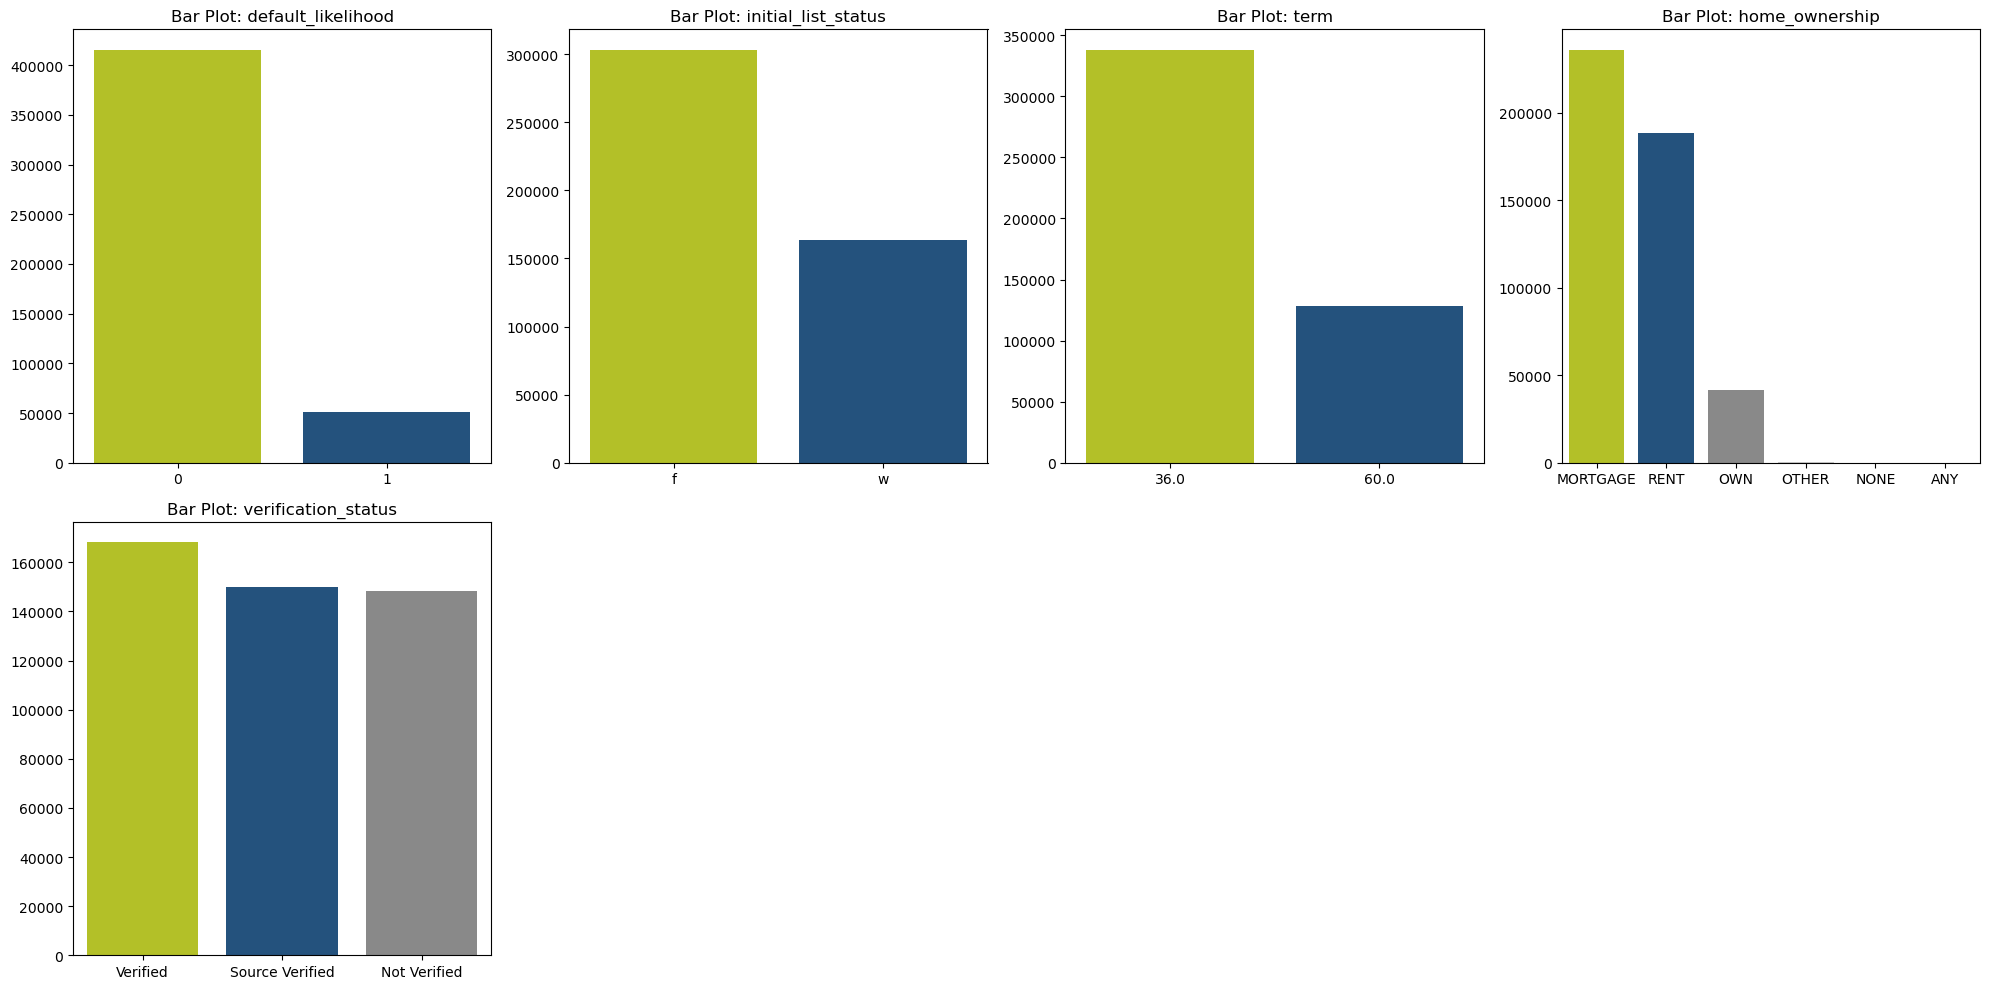

In [353]:
cols_to_plot = ['default_likelihood',
 'initial_list_status',
 'term',
 'home_ownership',
 'verification_status']
custom_functions_list = [
    custom_barplot, custom_barplot, custom_barplot, custom_barplot, custom_barplot
]

withingrid_col_per_function(df_basic, cols_to_plot, custom_functions_list=custom_functions_list, figsize=(20, 10))



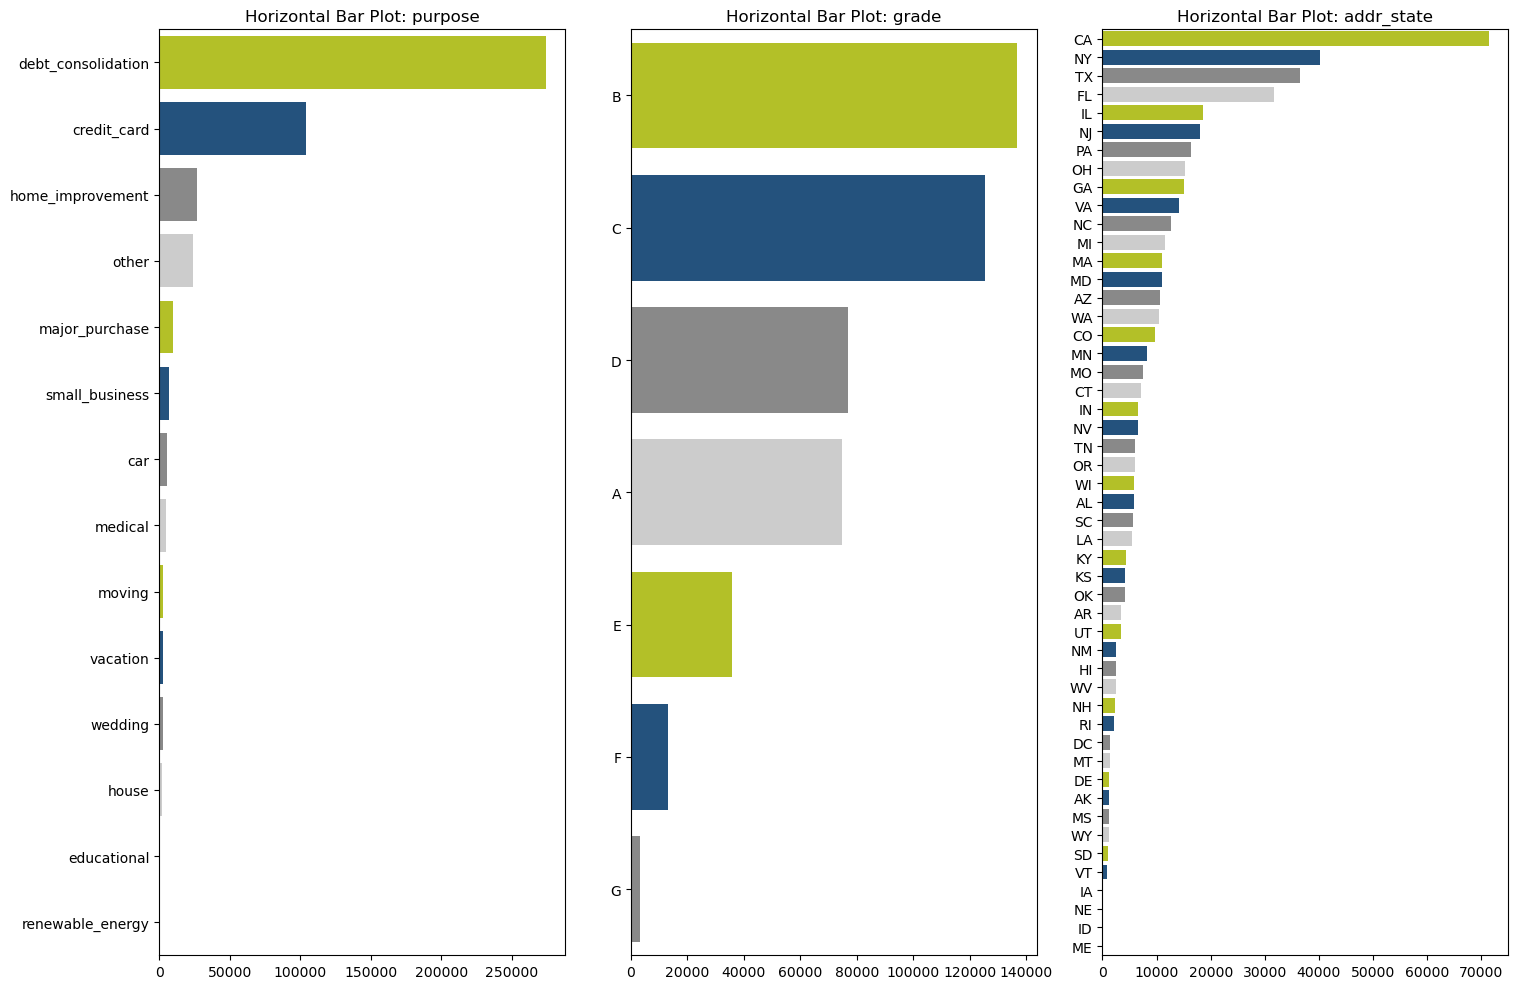

In [354]:
def custom_hor_barplot(df, column, ax, custom_palette=None):
    value_counts = df[column].value_counts()
    sns.barplot(x=value_counts.values, y=value_counts.index, data=df, ax=ax, palette=custom_palette)
    ax.set_title(f'Horizontal Bar Plot: {column}')
cols_to_plot = ['purpose','grade', 'addr_state']
custom_function = custom_hor_barplot 

withingrid_function_per_cols(df_basic, cols_to_plot, custom_function, figsize=(20, 10))



In [302]:
used_numerical

['acc_now_delinq',
 'annual_inc',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'delinq_2yrs',
 'dti',
 'earliest_cr_line_Year',
 'emp_length',
 'funded_amnt',
 'funded_amnt_inv',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'issue_d_Year',
 'last_credit_pull_d_Year',
 'last_pymnt_amnt',
 'last_pymnt_d_Year',
 'loan_amnt',
 'mths_since_last_delinq',
 'next_pymnt_d_Year',
 'open_acc',
 'out_prncp',
 'out_prncp_inv',
 'pub_rec',
 'recoveries',
 'revol_bal',
 'revol_util',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_acc',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_int',
 'total_rec_late_fee',
 'total_rec_prncp',
 'total_rev_hi_lim']

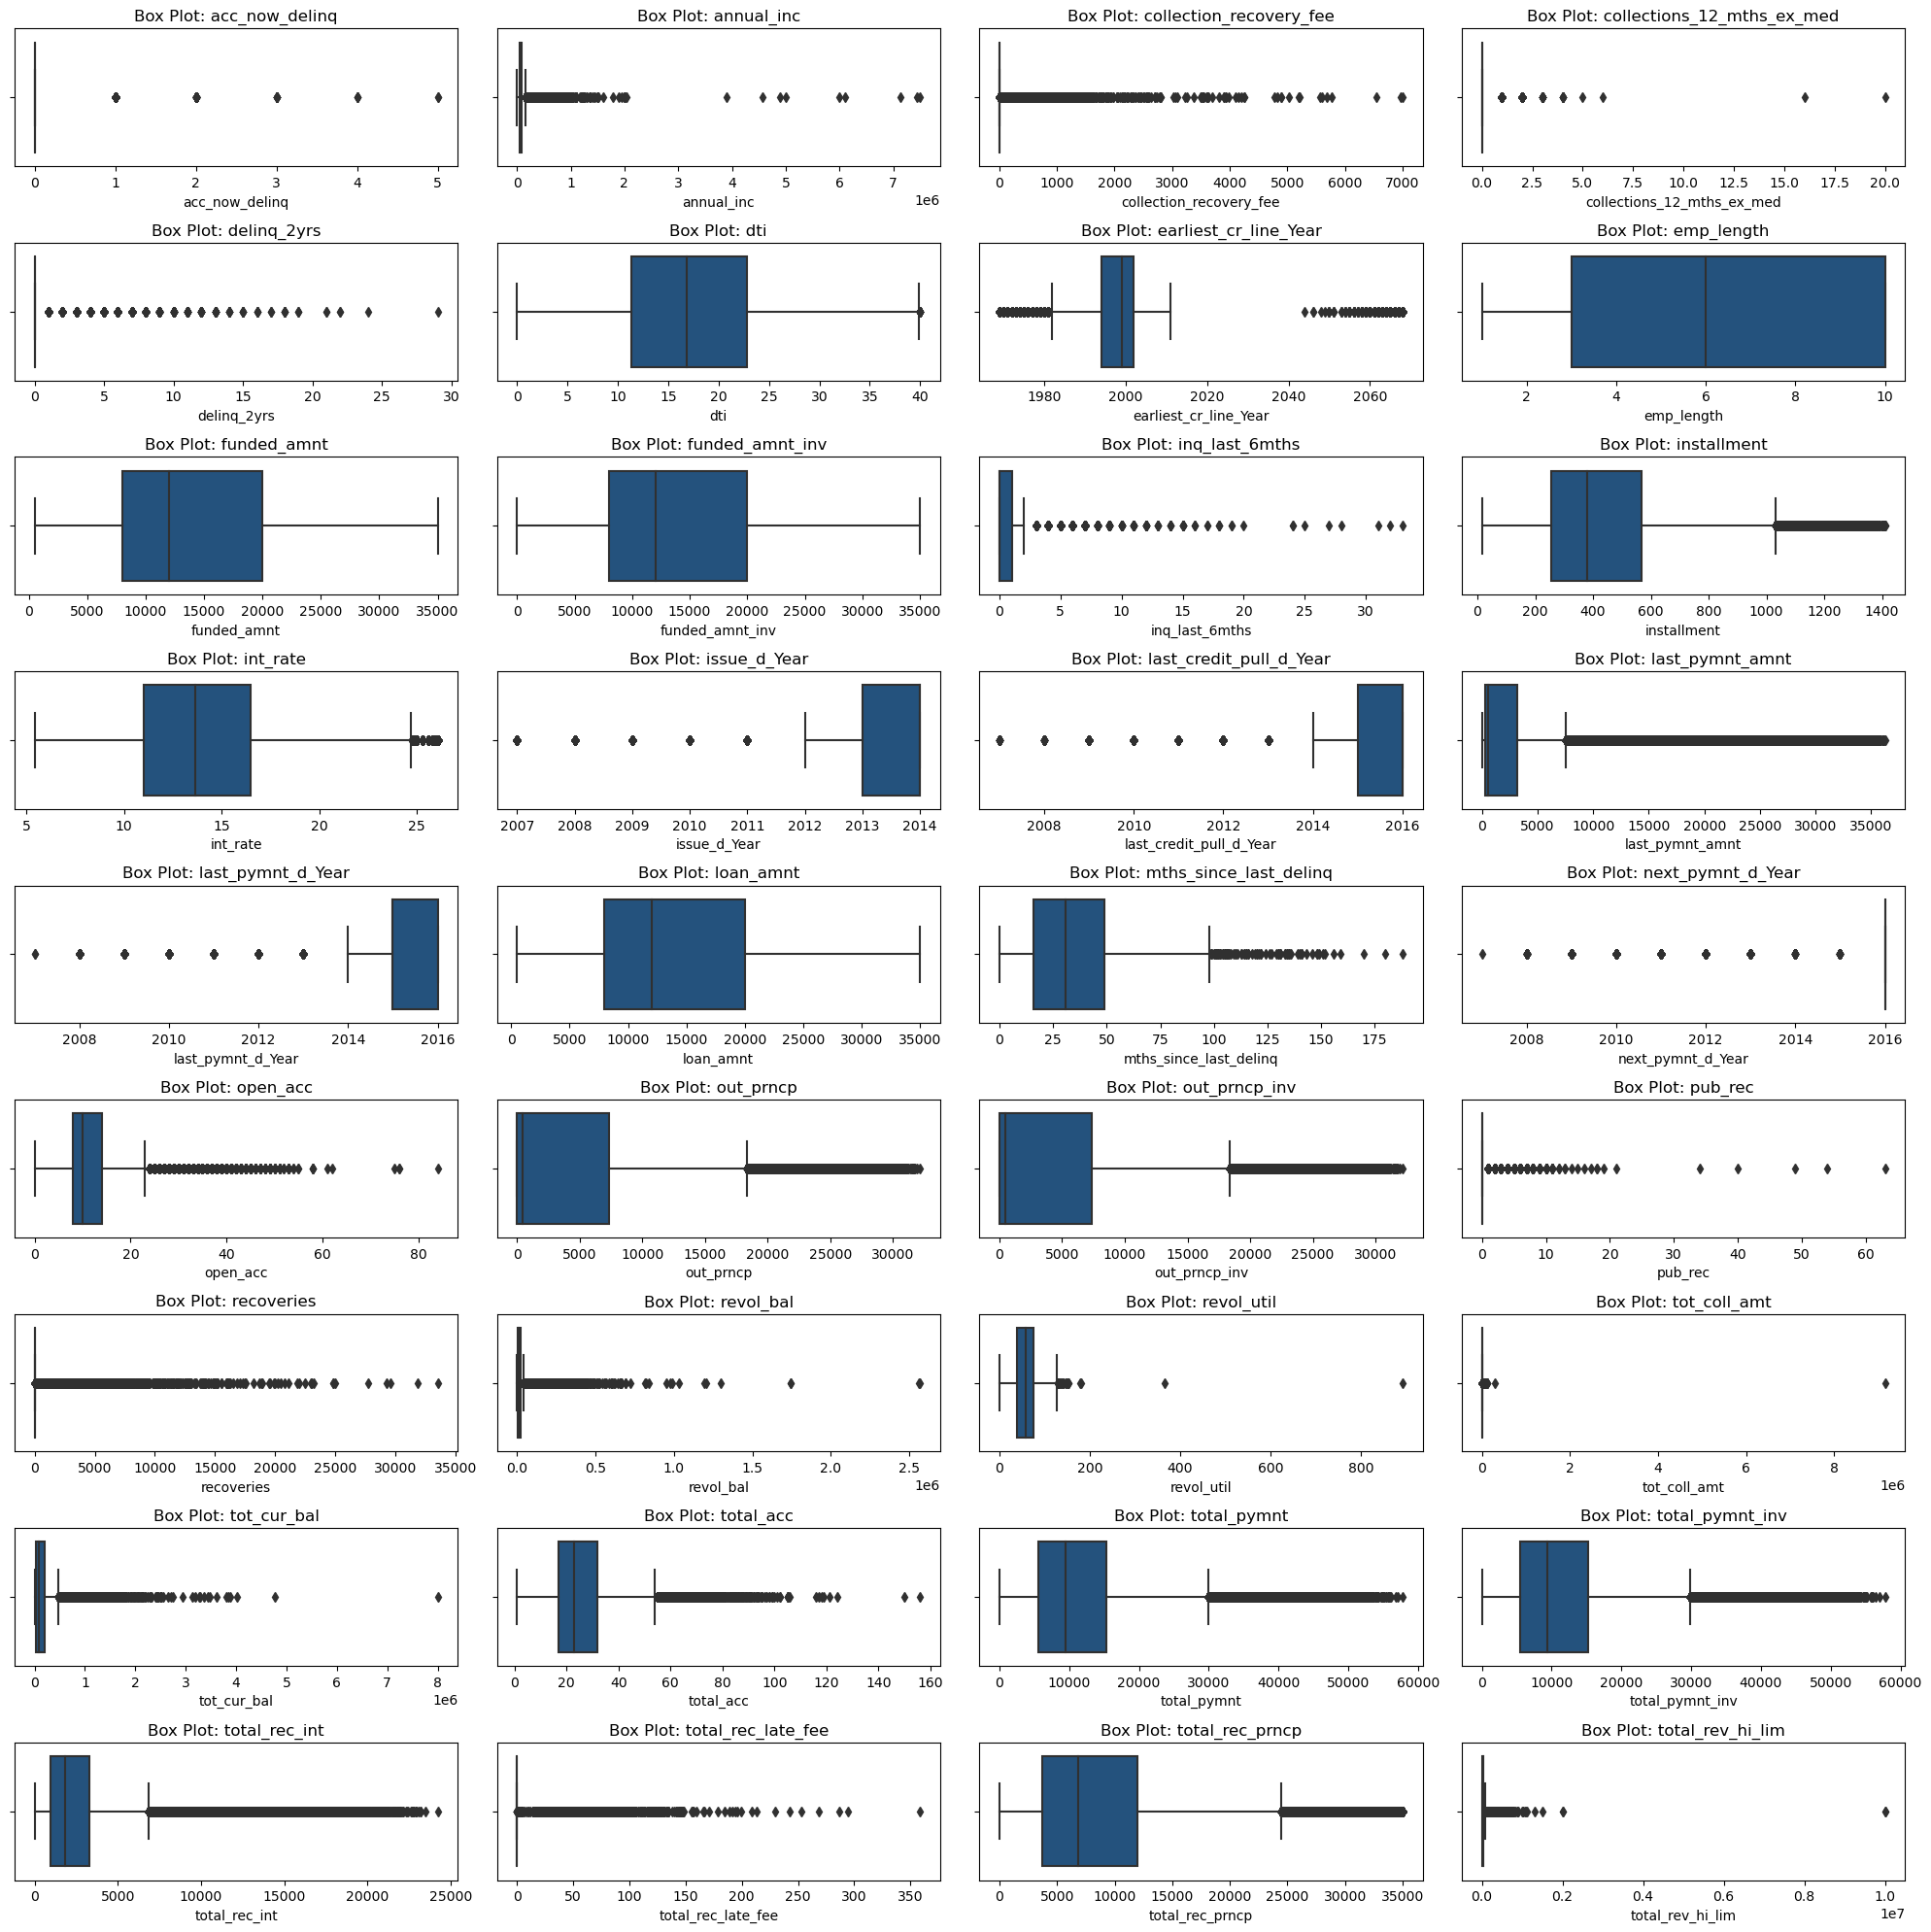

In [352]:
cols_to_plot = used_numerical
custom_function = custom_boxplot

withingrid_function_per_cols(df_basic, cols_to_plot, custom_function, figsize=(20, 20))

### Multivariate Analysis

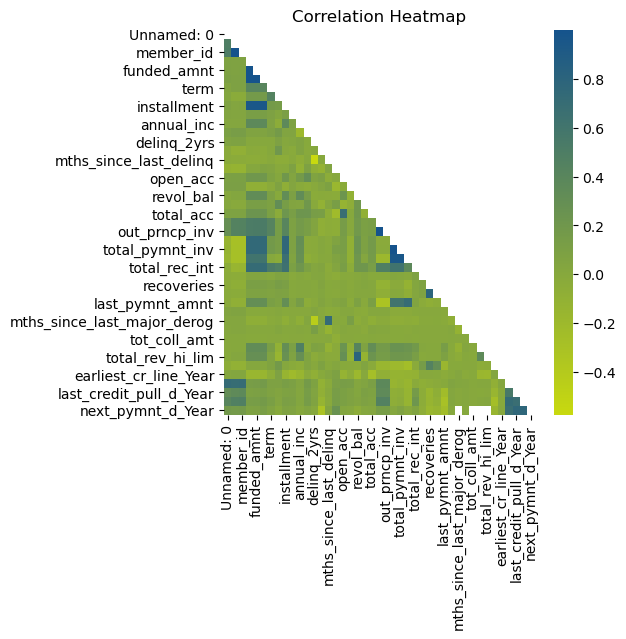

In [358]:
plt.figure(figsize=(5, 5))
ax = plt.gca()
corr_matrix = custom_heatmap(df_basic, ax)
plt.show()

# DATA PREPARATION PHASE (PART 2)

- There is no duplicated data so no treatment is necessary.
- Models robust to outliers will be used during modeling so there is no need to handle outlers.

## Data Cleansing

### Unnecessary features removal

In [304]:
# Load your dataset
df_basic_prep = df_basic.copy()
df_basic_prep = df_basic_prep.drop(columns=unnecessary_categorical)
df_basic_prep = df_basic_prep.drop(columns=unnecessary_numerical)
df_basic_prep = df_basic_prep.drop(columns=basic_temporal)
cat_binary, cat_other, temporal, numerical = type_columns(df_basic_prep,True)
categorical = join_column_lists(cat_binary, cat_other)

## Features/Label Split

In [305]:
# Define your data preprocessing steps
X = df_basic_prep.drop('default_likelihood', axis=1)
y = df_basic_prep['default_likelihood']


## Train/Test Data Split (Leakeage Prevention)

In [306]:
# Split the balanced data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Usage example
check_feature_consistency(X_train, X_test)

Feature sets in training and test data are consistent.


In [307]:
numerical_cols, categorical_cols = list_column_types(X_train)

Numerical Columns:
Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'earliest_cr_line_Year', 'issue_d_Year', 'last_credit_pull_d_Year',
       'last_pymnt_d_Year', 'next_pymnt_d_Year'],
      dtype='object')

Categorical Columns:
Index(['grade', 'home_ownership', 'verification_status', 'purpose',
       'addr_state', 'initial_list_status', 'earliest_cr_line_Month',
       'issue_d_Month', 'last_credit_pull_d_Month', 'last_pymnt_d_Month',
       'next_pymnt_d_Mon

In [308]:
## Feature Engineering Part 2

## Handling Missing Values

In [309]:
# Performing Imputation
# With Data Split
X_train_Imp, X_test_Imp = impute_data(X_train, split_data=True, X_test=X_test, drop_all=False)  # Imputing rows with missing values
check_feature_consistency(X_train_Imp, X_test_Imp)
numerical_cols, categorical_cols = list_column_types(X_train_Imp)


Feature sets in training and test data are consistent.
Numerical Columns:
Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'earliest_cr_line_Year', 'issue_d_Year', 'last_credit_pull_d_Year',
       'last_pymnt_d_Year', 'next_pymnt_d_Year'],
      dtype='object')

Categorical Columns:
Index(['grade', 'home_ownership', 'verification_status', 'purpose',
       'addr_state', 'initial_list_status', 'earliest_cr_line_Month',
       'issue_d_Month', 'last_credit_pull_d

## Feature Engineering

### Feature Encoding & Scaling

In [310]:
# Concatenate the training and testing data for one-hot encoding
X_concatenated = pd.concat([X_train_Imp, X_test_Imp])

# Identify categorical features
categorical_features = X_concatenated.select_dtypes(include=['object']).columns
numerical_features = X_concatenated.select_dtypes(exclude=['object']).columns

# Apply one-hot encoding to the concatenated data
categorical_encoded = one_hot_encode(X_concatenated)
numerical_scaled = scale_features(X_concatenated, scaler_type='Robust')

# Concatenate the numerical columns with the one-hot encoded categorical columns
X_encoded_scaled = pd.concat([categorical_encoded, numerical_scaled], axis=1)

# Split the encoded data back into training and testing datasets
X_train_ready = X_encoded_scaled.iloc[:len(X_train_Imp)]
X_test_ready = X_encoded_scaled.iloc[len(X_train_Imp):]

In [311]:
check_feature_consistency(X_train_ready, X_train_ready)
numerical_cols, categorical_cols = list_column_types(X_train_ready)

Feature sets in training and test data are consistent.
Numerical Columns:
Index(['grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN',
       ...
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'earliest_cr_line_Year',
       'issue_d_Year', 'last_credit_pull_d_Year', 'last_pymnt_d_Year',
       'next_pymnt_d_Year'],
      dtype='object', length=168)

Categorical Columns:
Index([], dtype='object')


## Handling Class Imbalance - Variations for Sensitivity Analysis

In [312]:
class_text = ["0, no default","1, yes default"]

## Variation 1:

In [313]:
#variation 1:
X_train_oversampled, y_train_oversampled = balance("oversampling", X_train_ready, y_train, y, class_text)

Handling class balance in default_likelihood
Proportion of 0, no default: 89.07%
Proportion of 1, yes default: 10.93%
0    332254
1     40774
Name: default_likelihood, dtype: int64
---------------------------------------------------------------------------
After Oversampling:
Proportion of 0, no default: 50.00%
Proportion of 1, yes default: 50.00%
0    332254
1    332254
Name: default_likelihood, dtype: int64


## Variation 2

In [314]:
#variation 2:
X_train_undersampled, y_train_undersampled = balance("undersampling", X_train_ready, y_train, y, class_text)

Handling class balance in default_likelihood
Proportion of 0, no default: 89.07%
Proportion of 1, yes default: 10.93%
0    332254
1     40774
Name: default_likelihood, dtype: int64
---------------------------------------------------------------------------
After Undersampling:
Proportion of 0, no default: 50.00%
Proportion of 1, yes default: 50.00%
0    40774
1    40774
Name: default_likelihood, dtype: int64


## Feature Selection

In [315]:
df_heatmap = X_train_oversampled

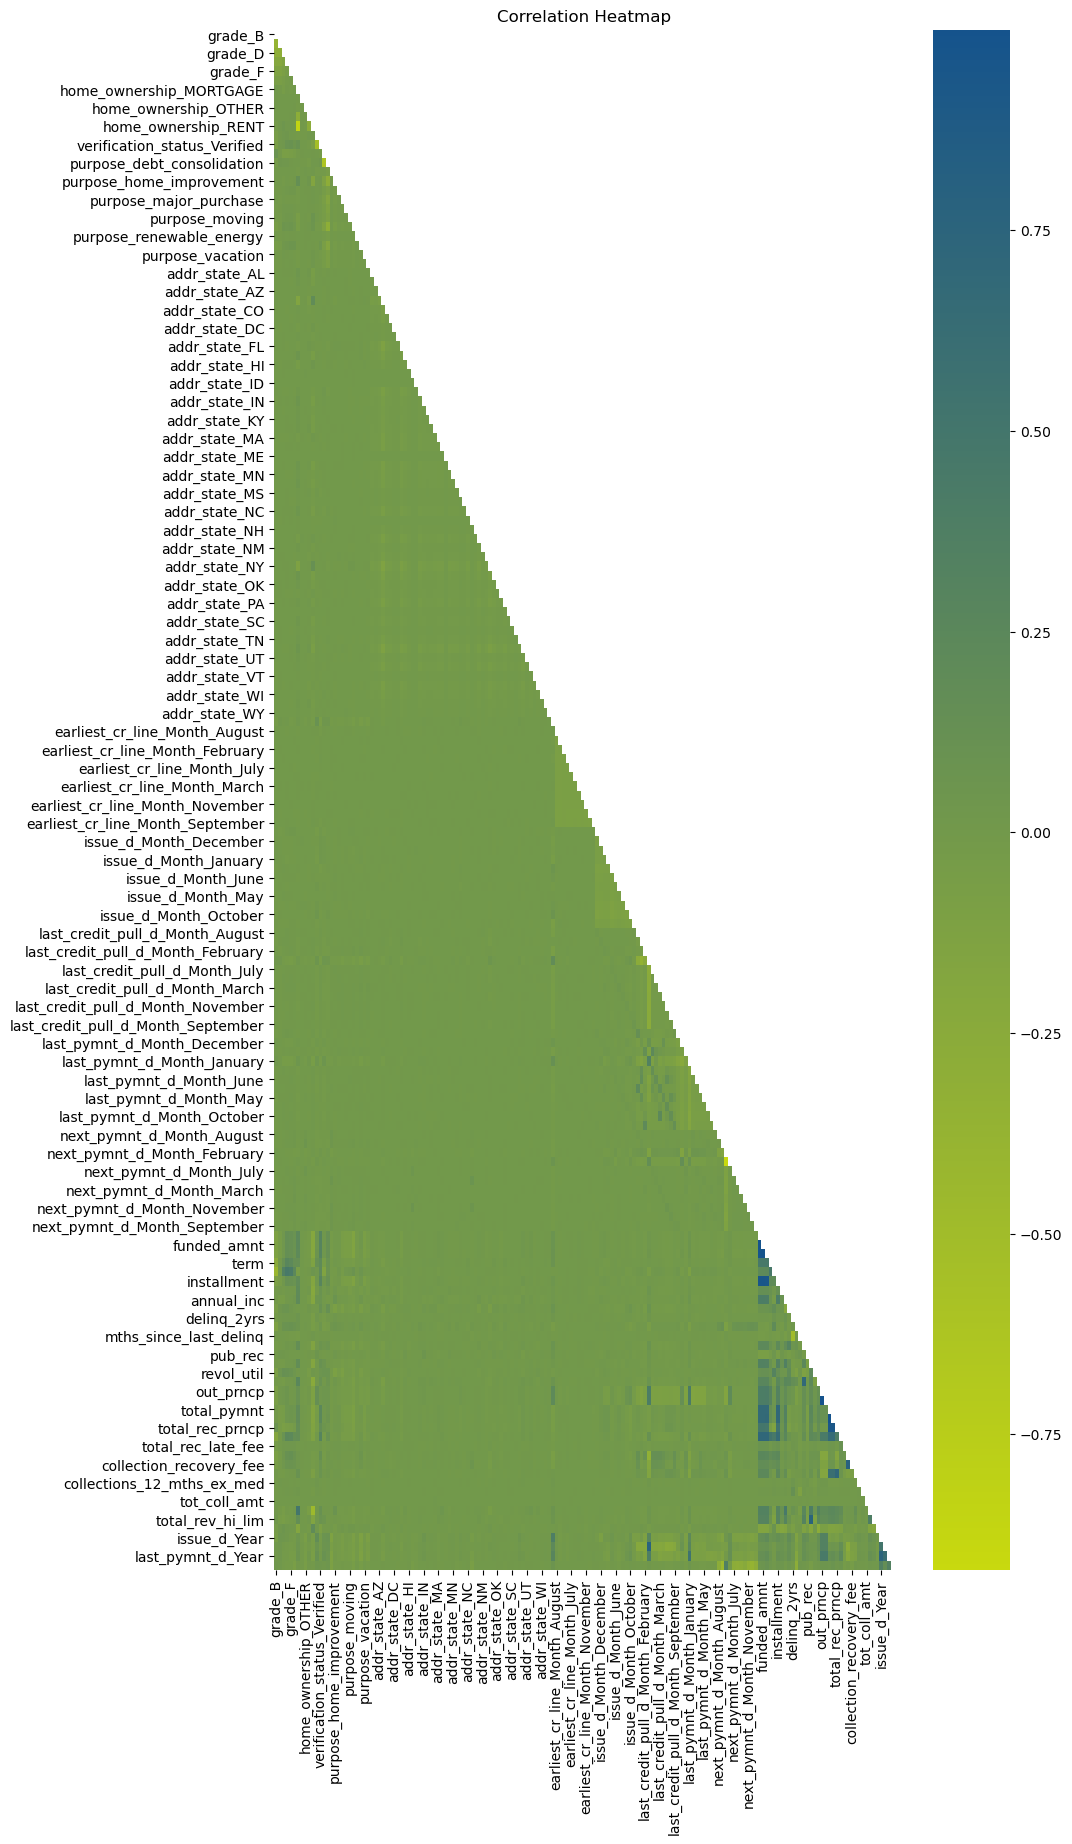

Pairs of features with high correlation between them:
home_ownership_RENT and home_ownership_MORTGAGE
next_pymnt_d_Month_January and next_pymnt_d_Month_February
funded_amnt and loan_amnt
funded_amnt_inv and loan_amnt
funded_amnt_inv and funded_amnt
installment and loan_amnt
installment and funded_amnt
installment and funded_amnt_inv
out_prncp_inv and out_prncp
total_pymnt_inv and total_pymnt
total_rec_prncp and total_pymnt
total_rec_prncp and total_pymnt_inv
---------------------------------------------------------------------------
Features to remove due to high correlation:
['funded_amnt', 'next_pymnt_d_Month_February', 'home_ownership_RENT', 'total_pymnt', 'funded_amnt_inv', 'loan_amnt', 'next_pymnt_d_Month_January', 'total_pymnt_inv', 'total_rec_prncp', 'out_prncp', 'home_ownership_MORTGAGE', 'installment', 'out_prncp_inv']


In [355]:
plt.figure(figsize=(10, 20))
ax = plt.gca()
corr_matrix = custom_heatmap(df_heatmap, ax)
plt.show()

print("Pairs of features with high correlation between them:")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) >= 0.8:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}")
features_to_drop = set()
for pair in high_corr_pairs:
    features_to_drop.update(pair)
high_corr_features = list(features_to_drop)
print("-"*75)
print("Features to remove due to high correlation:")
print(high_corr_features)

### Highly correlated features removal

In [317]:
X_train_var1 = X_train_oversampled.drop(columns=high_corr_features)
X_test_var1 = X_test_ready.drop(columns=high_corr_features)

In [318]:
X_train_var2 = X_train_undersampled.drop(columns=high_corr_features)
X_test_var2 = X_test_ready.drop(columns=high_corr_features)

In [319]:
check_feature_consistency(X_train_var1, X_test_var1)

Feature sets in training and test data are consistent.


In [320]:
original_rows = df_original.shape[0]
original_columns = df_original.shape[1]
preprocessed_rows = X_train_var1.shape[0]
preprocessed_columns =  X_train_var1.shape[1]
table_title = ["Before and After Preparing the Data:"]
column_titles = ["Original Dataframe", '', "Preprocessed Dataframe"]
result1 = ['Columns; ' + str(original_columns)], ['Rows: ' + str(original_rows)]
result2 = ['Columns: ' + str(preprocessed_columns)], ['Rows: ' + str(preprocessed_rows)]
print_table(table_title, column_titles, result1, '', result2)

| ['Before and After Preparing the Data:']   |    |                        |
|:-------------------------------------------|:---|:-----------------------|
| Original Dataframe                         |    | Preprocessed Dataframe |
|                                            |    |                        |
| ['Columns; 75']                            |    | ['Columns: 155']       |
| ['Rows: 466285']                           |    | ['Rows: 664508']       |


# MODELING PHASE

## Model Training and Evaluation

In [321]:
# Define the models and hyperparameters
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


def train_models(X_train, y_train, X_test, y_test, models):
    trained_models = []
    for model, model_name in models:
        print(f'Training {model_name}:')
        model.fit(X_train, y_train)
        print("Finished")
        trained_models.append((model_name, model))
    print("All models have Finished training.")
    return trained_models

def evaluate_models(trained_models, X_test, y_test):
    results = []
    for i, (model_name, _) in enumerate(trained_models):
        model = trained_models[i][1]
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        print(f'{model_name} F1 Score: {f1:.2f}')
        results.append((model_name, f1))
    return results

In [322]:
# Define the models 
models = [
    (LGBMClassifier(verbosity=-1), 'LightGBM'),
    (XGBClassifier(), 'XGBoost'),
]

hyperparameters = {
    'LightGBM': {
        'n_estimators': [10, 25, 50],
        'max_depth': [5, 10, 15],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'XGBoost': {
        'n_estimators': [10, 25, 50],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}


In [323]:
# Variation 1 (Oversampled)

In [324]:
print("Training models without tuning:")
var1_trained_models_no_tuning = train_models(X_train_var1, y_train_oversampled, X_test_var1, y_test, models)

Training models without tuning:
Training LightGBM:
Finished
Training XGBoost:
Finished
All models have Finished training.


In [325]:
print("Evaluating models without tuning:")
var1_results_no_tuning = evaluate_models(var1_trained_models_no_tuning, X_test_var1, y_test)

Evaluating models without tuning:
LightGBM F1 Score (Hyperparameter Tuning): 0.94
XGBoost F1 Score (Hyperparameter Tuning): 0.95


- The F1 Score is lower in Variation 2: Undersampling.

In [326]:
# Variation 2 (Undersampled)

In [327]:
print("Training models without without tuning:")
var2_trained_models_no_tuning = train_models(X_train_var2, y_train_undersampled, X_test_var2, y_test, models)

Training models without without tuning:
Training LightGBM:
Finished
Training XGBoost:
Finished
All models have Finished training.


In [328]:
print("Evaluating models without hyperparameter tuning:")
results_no_tuning = evaluate_models(var2_trained_models_no_tuning, X_test_var2, y_test)

Evaluating models without hyperparameter tuning:
LightGBM F1 Score (Hyperparameter Tuning): 0.91
XGBoost F1 Score (Hyperparameter Tuning): 0.91


# Hyperparameter tuning


In [329]:
from sklearn.model_selection import RandomizedSearchCV

def tune_model(X_train, y_train, model, model_name, param_distributions, n_iter=10, scoring='f1'):
    print(f'Tuning {model_name} using Randomized Search:')
    randomized_search = RandomizedSearchCV(model, param_distributions=param_distributions, n_iter=n_iter, scoring=scoring, cv=3, random_state=42)
    randomized_search.fit(X_train, y_train)
    
    best_model = randomized_search.best_estimator_
    best_params = randomized_search.best_params_
    best_score = randomized_search.best_score_
    
    print(f'Best {model_name} Hyperparameters: {best_params}')
    print(f'Best {model_name} {scoring} Score: {best_score:.2f}')
    
    return best_model, best_params

In [330]:
tuned_models = []
for model, model_name in models:
    best_model, best_params = tune_model(X_train_var1, y_train_oversampled, model, model_name, hyperparameters[model_name])
    tuned_models.append((best_model, model_name))

Tuning LightGBM using Randomized Search:
Best LightGBM Hyperparameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1}
Best LightGBM f1 Score: 0.99
Tuning XGBoost using Randomized Search:
Best XGBoost Hyperparameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.1}
Best XGBoost f1 Score: 0.99


In [331]:
var1_trained_models_tuned = train_models(X_train_var1, y_train_oversampled, X_test_var1, y_test, tuned_models)
results_tuned = evaluate_models(var1_trained_models_tuned, X_test_var1, y_test)

Training LightGBM:
Finished
Training XGBoost:
Finished
All models have Finished training.
LightGBM F1 Score (Hyperparameter Tuning): 0.93
XGBoost F1 Score (Hyperparameter Tuning): 0.93


In [332]:
def display_results(results):
    df = pd.DataFrame(results, columns=['Model', 'F1 Score'])
    return df

In [333]:
# Combine the results of tuned and not tuned models
all_results = var1_results_no_tuning + results_tuned

# Display the combined results using the display_results function
combined_results_df = display_results(all_results)

# Display the combined results DataFrame
print("Combined Results:")
print(combined_results_df)

Combined Results:
      Model  F1 Score
0  LightGBM  0.939079
1   XGBoost  0.945001
2  LightGBM  0.931628
3   XGBoost  0.934234


In [334]:
import pandas as pd
from tabulate import tabulate

# Convert the lists of tuples to DataFrames
before_tuning_df = pd.DataFrame(var1_results_no_tuning, columns=['Model (Not Tuned)', 'F1 Score (Not Tuned)'])
after_tuning_df = pd.DataFrame(results_tuned, columns=['Model (Tuned)', 'F1 Score (Tuned)'])

# Create a new DataFrame to format the headers
formatted_combined_results = pd.concat([before_tuning_df, after_tuning_df], axis=1)

# Define your custom headers
custom_headers = ['Before Tuning', 'F1', 'After Tuning', 'F1']

# Display the formatted combined results as a table with '-' replaced by empty spaces
table = tabulate(formatted_combined_results, headers=custom_headers, tablefmt='fancygrid', showindex=False)

# Replace '-' with empty spaces
table = table.replace('|', ' ')

print("Formatted Combined Results:")
print(table)


Formatted Combined Results:
Before Tuning          F1  After Tuning          F1
---------------  --------  --------------  --------
LightGBM         0.939079  LightGBM        0.931628
XGBoost          0.945001  XGBoost         0.934234


In [335]:
import matplotlib.pyplot as plt
selection = var1_trained_models_no_tuning
model = selection[1][1]

In [336]:
import shap
import matplotlib.pyplot as plt

def explain_model_with_shap(model, X_test):
    # Initialize a SHAP explainer using the model
    explainer = shap.Explainer(model)

    # Compute SHAP values for the test data
    shap_values = explainer.shap_values(X_test)

    # Calculate the mean SHAP values
    mean_shap_values = shap_values.mean(axis=0)

    # Create a summary plot to visualize feature importance with red and blue colors
    shap.summary_plot(shap_values, X_test, show=True)
    shap.summary_plot(shap_values, X_test, plot_type="bar")
    plt.show()


# Usage example:
# Pass your trained model and the test data (X_test) to the function
# explain_model_with_shap(your_trained_model, X_test)




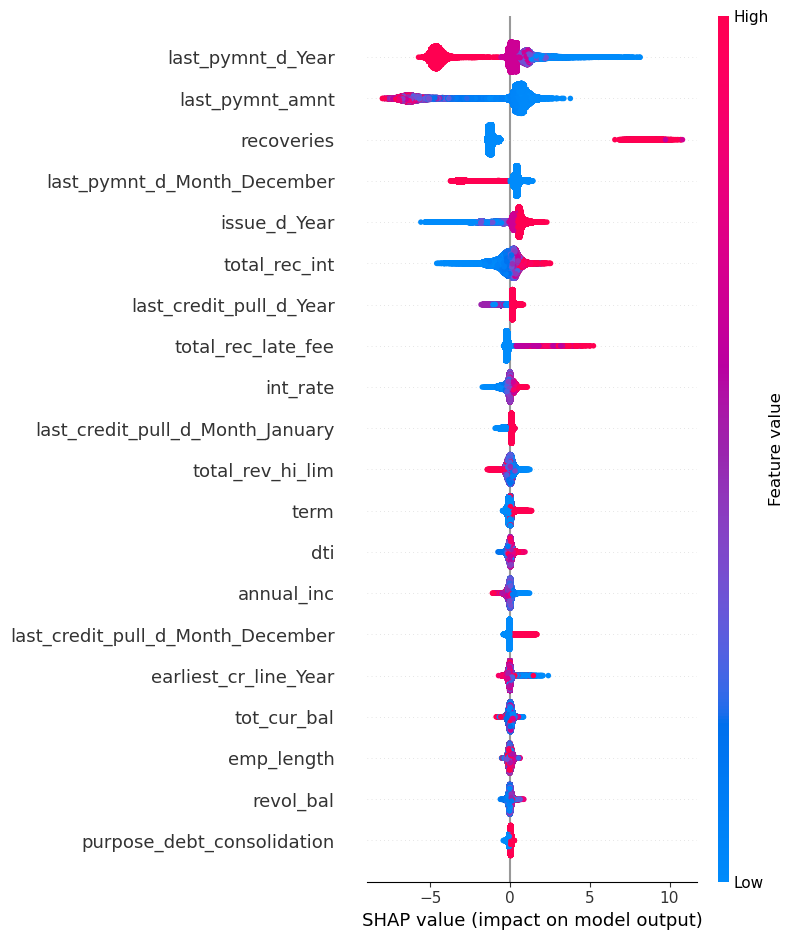

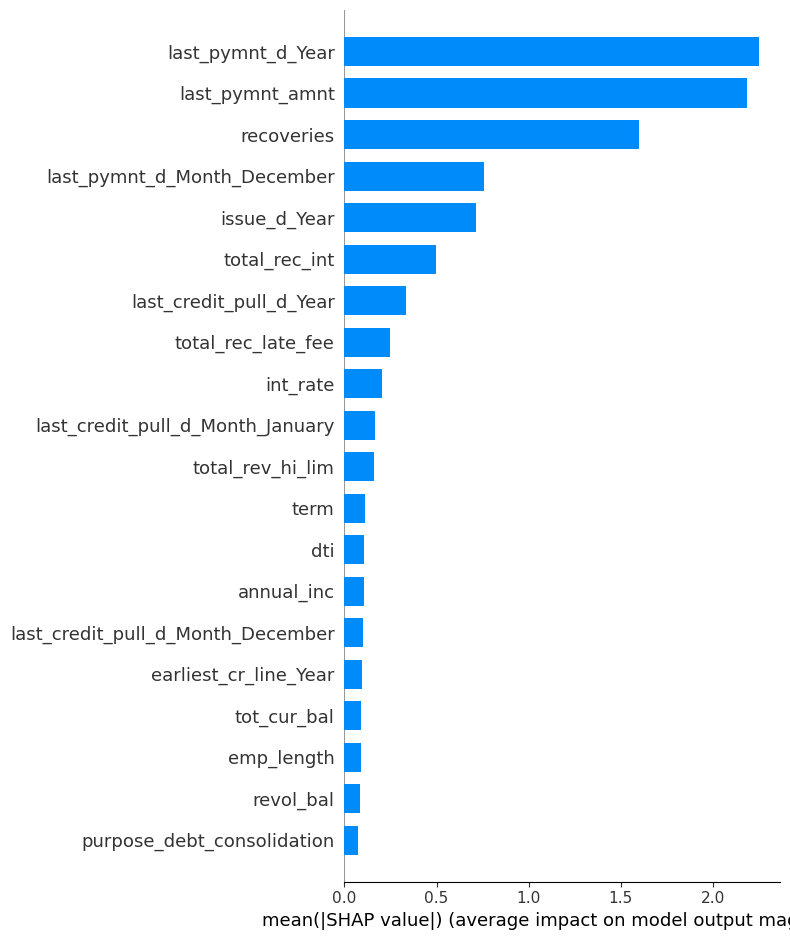

In [337]:
explain_model_with_shap(model, X_test_var1)